<a href="https://colab.research.google.com/github/YOUbhrt/DL-PROJECT/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SKIN LESIONS CLASSIFICATION WITH PRETRAINED VGG16 MODEL 

Importation libraries needed

In [ ]:
import json
import math
import os
import cv2
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from sklearn import metrics

from PIL import Image


from keras import layers
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from glob import glob
from keras import Model
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

import scipy
from tqdm import tqdm
import tensorflow as tf
from keras import backend as K
import gc
from functools import partial

from collections import Counter
import json
import itertools
%matplotlib inline



## Load the Data from Kaggle

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

In [ ]:
files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"elhaliamina","key":"130cd80046a793218c4e2b6e69f15476"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download "nodoubttome/skin-cancer9-classesisic"


kaggle.json
skin-cancer9-classesisic.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip skin-cancer9-classesisic.zip

Archive:  skin-cancer9-classesisic.zip
replace Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_00246

Extract Train and Test files direction

In [ ]:
DATADIR_Train = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train'
DATADIR_Test = '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test'

Extract the categories of skin lession

In [ ]:
CATEGORIES  = list()
for root, dirs, files in os.walk(DATADIR_Train, topdown=False):
    for name in dirs:
        CATEGORIES.append(os.path.join(name))
print (CATEGORIES)

['actinic keratosis', 'seborrheic keratosis', 'basal cell carcinoma', 'nevus', 'squamous cell carcinoma', 'melanoma', 'pigmented benign keratosis', 'dermatofibroma', 'vascular lesion']


Now let's divide the data Train and Test to X and Y(label).

In [ ]:
x_train_data = []
y_train_data = []
IMG_SIZE=224
#create training data in x and y(label)
def create_training_data():
    for category in CATEGORIES:
      path = os.path.join(DATADIR_Train, category)
      class_num = CATEGORIES.index(category) #mapping categories to index
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE)) #resize imges to IMG_SIZE
            x_train_data.append(new_array)
            y_train_data.append(class_num)
        except Exception as e:
            pass
create_training_data()

In [ ]:

x_test_data = []
y_test_data = []
IMG_SIZE=224
#create testing data in x and y(label)
def create_testing_data():
    for category in CATEGORIES:
      path = os.path.join(DATADIR_Test, category)
      class_num = CATEGORIES.index(category) #mapping categories to index
      for img in os.listdir(path):
        try:
            img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
            new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE)) #resize imges to IMG_SIZE
            x_test_data.append(new_array)
            y_test_data.append(class_num)
        except Exception as e:
            pass
create_testing_data()

Split the Train DATA to Train and Validation, and show the shape of eache X and Y data.

In [ ]:
X_Train, X_Val, Y_Train, Y_Val = train_test_split(x_train_data, y_train_data, test_size=0.02, random_state=1)

Reshape the Dataset

In [ ]:
X_Train = np. squeeze(np.array(X_Train))
X_Val = np. squeeze(np.array(X_Val))
Y_Train = np. squeeze(np.array(Y_Train))
Y_Val = np. squeeze(np.array(Y_Val))
x_test_data = np. squeeze(np.array(x_test_data))

In [ ]:
X_Train.shape

(2194, 224, 224, 3)

In [ ]:
Y_Train.shape

(2194,)

In [ ]:
x_test_data.shape

(118, 224, 224, 3)

In [ ]:
X_Val.shape

(45, 224, 224, 3)

In [ ]:
Y_Val.shape

(45,)

To launch the Train we need to make categories from Y_Train and X_Val.

In [ ]:
Y_Train = to_categorical(Y_Train)
Y_Val = to_categorical(Y_Val)

In [ ]:
Y_Train.shape

(2194, 9)

In [ ]:
Y_Val.shape

(45, 9)

In [ ]:
X_Val.shape

(45, 224, 224, 3)

In this netboke we classifie the data using a Pre-trained Model(VGG16).


So what is a Pre-trained Model?

> A pre-trained model is a model that has been previously trained on a dataset and contains the weights and biases that represent the features of whichever dataset it was trained on. Learned features are often transferable to different data. For example, a model trained on a large dataset of bird images will contain learned features like edges or horizontal lines that you would be transferable your dataset.




## The VGG16 Model





 VGG16 is a convolutional neural network model proposed by K. Simonyan and A. Zisserman from the University of Oxford in the paper “Very Deep Convolutional Networks for Large-Scale Image Recognition”. The model achieves 92.7% top-5 test accuracy in ImageNet, which is a dataset of over 14 million images belonging to 1000 classes. It was one of the famous model submitted to ILSVRC-2014. It makes the improvement over AlexNet by replacing large kernel-sized filters (11 and 5 in the first and second convolutional layer, respectively) with multiple 3×3 kernel-sized filters one after another. VGG16 was trained for weeks and was using NVIDIA Titan Black GPU’s.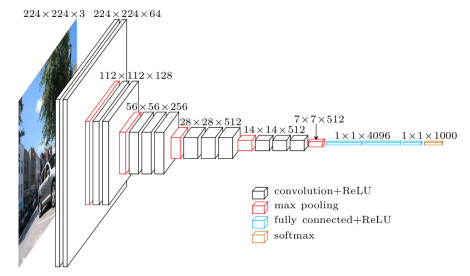







The input to cov1 layer is of fixed size 224 x 224 RGB image. The image is passed through a stack of convolutional (conv.) layers, where the filters were used with a very small receptive field: 3×3 (which is the smallest size to capture the notion of left/right, up/down, center). In one of the configurations, it also utilizes 1×1 convolution filters, which can be seen as a linear transformation of the input channels (followed by non-linearity). The convolution stride is fixed to 1 pixel; the spatial padding of conv. layer input is such that the spatial resolution is preserved after convolution, i.e. the padding is 1-pixel for 3×3 conv. layers. Spatial pooling is carried out by five max-pooling layers, which follow some of the conv. layers (not all the conv. layers are followed by max-pooling). Max-pooling is performed over a 2×2 pixel window, with stride 2.

### **Load in Pretrained the VGG16** 

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [ ]:
IMG_SHAPE = (224, 224,3)

In [ ]:
base_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

Show the layers

In [ ]:
for layer in base_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(base_model.layers))

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
19


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Extract the last layer output.

In [ ]:
last_layer = base_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 7, 7, 512)


First we freeze all layers in VGG16

In [ ]:
base_model.trainable = False

In [ ]:
base_model.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model

%matplotlib inline
tf.__version__

'2.4.0'

### **Build the model**

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(base_model.output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(9, activation='softmax')(x)

# Configure and compile the model
model = Model(base_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

Augmentation and normalization of data 

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255, rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest')

In [ ]:
train_datagen.fit(X_Train)

In [ ]:
val_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen.fit(X_Val)

In [ ]:
history = model.fit(X_Train, Y_Train, batch_size=64, epochs=20,
                    validation_data=(X_Val, Y_Val))

Epoch 1/20
35/35 [==============================] - 10s 268ms/step - loss: 27.9272 - accuracy: 0.1597 - val_loss: 13.5600 - val_accuracy: 0.1778
Epoch 2/20
35/35 [==============================] - 10s 273ms/step - loss: 18.8703 - accuracy: 0.2203 - val_loss: 11.5109 - val_accuracy: 0.2667
Epoch 3/20
35/35 [==============================] - 9s 266ms/step - loss: 14.8746 - accuracy: 0.2786 - val_loss: 9.8891 - val_accuracy: 0.3333
Epoch 4/20
35/35 [==============================] - 9s 258ms/step - loss: 11.9702 - accuracy: 0.3269 - val_loss: 8.9546 - val_accuracy: 0.3556
Epoch 5/20
35/35 [==============================] - 9s 252ms/step - loss: 10.0415 - accuracy: 0.3052 - val_loss: 8.0725 - val_accuracy: 0.4000
Epoch 6/20
35/35 [==============================] - 9s 249ms/step - loss: 8.0782 - accuracy: 0.3601 - val_loss: 6.9999 - val_accuracy: 0.3556
Epoch 7/20
35/35 [==============================] - 9s 248ms/step - loss: 6.7168 - accuracy: 0.3685 - val_loss: 6.4488 - val_accuracy: 0.37

## Fine Tuning Model

Let's fine tune the last convolutional block of VGG net. I only use learning_rate = 0.0001 with very high momentum = 0.9 and train for 30 epochs only so that the original weights of pretrained VGG net won't be changed too much. 

 unfreeze layers

In [ ]:
model.trainable = True

In [ ]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [ ]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

By setting the last convolutional block to trainable, we are now retraining for half of the hyperparameters

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

In [ ]:
history = model.fit(X_Train, Y_Train, batch_size=64, epochs=30,
                    validation_data=(X_Val, Y_Val))

Epoch 1/30
35/35 [==============================] - 29s 820ms/step - loss: 3.0096 - acc: 0.3021 - val_loss: 1.5530 - val_acc: 0.4222
Epoch 2/30
35/35 [==============================] - 28s 812ms/step - loss: 1.5956 - acc: 0.4151 - val_loss: 1.3736 - val_acc: 0.4889
Epoch 3/30
35/35 [==============================] - 29s 816ms/step - loss: 1.4479 - acc: 0.4781 - val_loss: 1.2629 - val_acc: 0.5778
Epoch 4/30
35/35 [==============================] - 29s 815ms/step - loss: 1.3334 - acc: 0.5364 - val_loss: 1.2564 - val_acc: 0.5333
Epoch 5/30
35/35 [==============================] - 29s 814ms/step - loss: 1.2064 - acc: 0.5917 - val_loss: 1.2575 - val_acc: 0.6000
Epoch 6/30
35/35 [==============================] - 28s 813ms/step - loss: 1.1759 - acc: 0.5807 - val_loss: 1.1280 - val_acc: 0.5778
Epoch 7/30
35/35 [==============================] - 28s 813ms/step - loss: 0.9763 - acc: 0.6661 - val_loss: 1.1136 - val_acc: 0.6000
Epoch 8/30
35/35 [==============================] - 28s 812ms/step - 

In [ ]:
loss_val, acc_val = model.evaluate(X_Val, Y_Val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

2/2 [==============================] - 0s 66ms/step - loss: 1.1936 - acc: 0.7111
Validation: accuracy = 0.711111  ;  loss_v = 1.193637


## Testing

In [ ]:
y_test_data = to_categorical(y_test_data)
loss_test, acc_test = model.evaluate(x_test_data, y_test_data, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

4/4 [==============================] - 0s 118ms/step - loss: 3.4007 - acc: 0.5085
Test: accuracy = 0.508475  ;  loss = 3.400678


In [ ]:
model.save("VGG16.h5")

Let's plot the each of accuracy and loss training and validation

Text(0.5, 1.0, 'Training and validation loss')

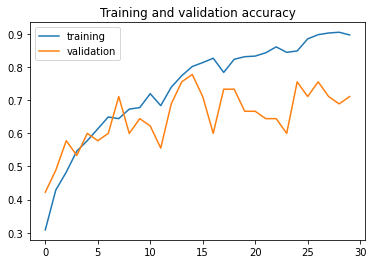

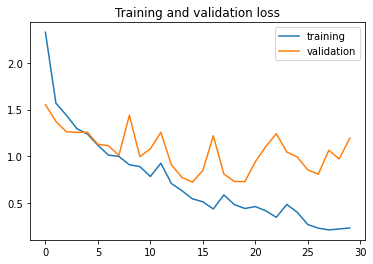

In [ ]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')